<a href="https://colab.research.google.com/github/Synaptic-Sparks/synaptic-sparks-code/blob/main/xAI_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset Download and Extraction

This section of the code automatically downloads the dataset from a public
Google Drive link and extracts it into the Google Colab runtime.

**Why this is needed:**
- Google Colab sessions are temporary and start empty each time.
- The dataset is not stored in the GitHub repository due to size limits.
- Downloading the dataset programmatically ensures reproducibility and allows
  anyone (e.g., the professor) to run the notebook without manual setup.

**Steps performed:**
1. Install `gdown`, a utility for downloading files from Google Drive.
2. Download the dataset ZIP file using its Google Drive file ID.
3. Verify that the downloaded file is valid by checking its size.
4. Unzip the dataset into the Colab filesystem for use in training and analysis.



In [2]:
!pip install -q gdown
import gdown
FILE_ID = "1DQffxIigWsoWyjd57Nd3xB0grtxx1-2i"
OUTPUT = "/content/ImageNetSubset.zip"

gdown.download(
    f"https://drive.google.com/uc?id={FILE_ID}",
    OUTPUT,
    quiet=False
)

!unzip -q ImageNetSubset.zip -d /content/dataset

Downloading...
From (original): https://drive.google.com/uc?id=1DQffxIigWsoWyjd57Nd3xB0grtxx1-2i
From (redirected): https://drive.google.com/uc?id=1DQffxIigWsoWyjd57Nd3xB0grtxx1-2i&confirm=t&uuid=3cb37287-81b3-4a17-b5e6-6c1e967a42b5
To: /content/ImageNetSubset.zip
100%|██████████| 1.29G/1.29G [00:17<00:00, 74.0MB/s]


### Data Augmentation Visualization

This section demonstrates how data augmentation is applied to training images
using TensorFlow's `ImageDataGenerator`. Data augmentation artificially increases
the diversity of the training dataset by applying random transformations to
existing images. This helps improve model generalization and reduces overfitting.

In this example, a single image from the dataset is augmented multiple times,
and the resulting transformed images are displayed in a grid.


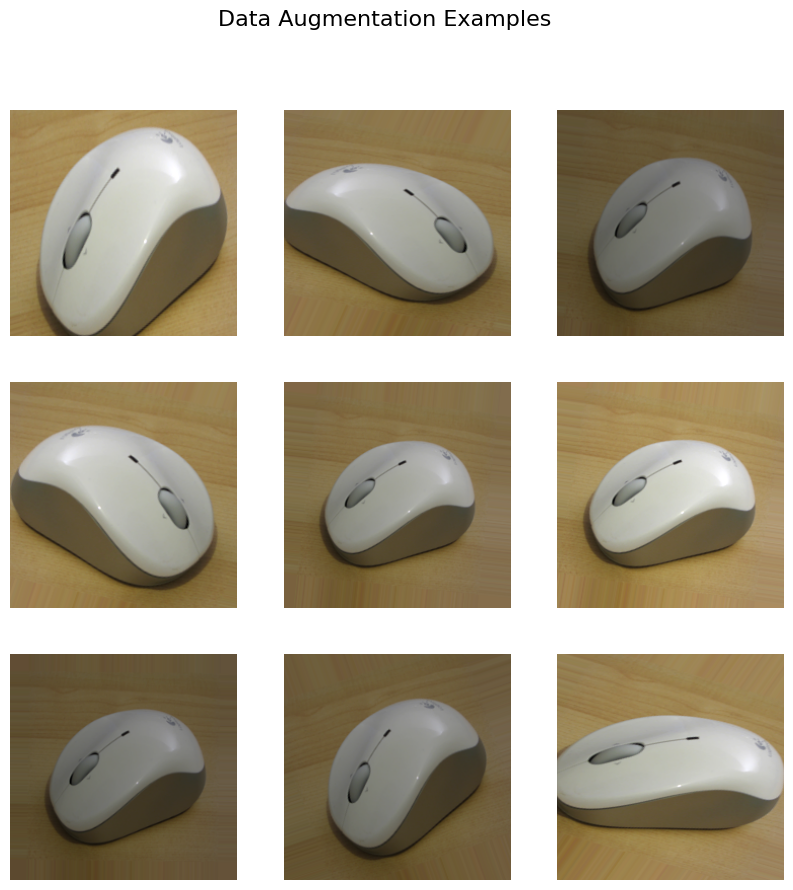

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image

sample_image_path = "/content/dataset/ImageNetSubset/train/mouse/n03793489_901.JPEG"

img = np.array(Image.open(sample_image_path).resize((224, 224)))

datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

img = img.reshape((1,) + img.shape)

aug_iter = datagen.flow(img, batch_size=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    batch = next(aug_iter)
    aug_img = batch[0].astype("uint8")
    plt.subplot(3, 3, i+1)
    plt.imshow(aug_img)
    plt.axis("off")

plt.suptitle("Data Augmentation Examples", fontsize=16)
plt.show()

### Class Distribution Analysis of the Training Dataset

This section analyzes the distribution of images across different classes
in the training dataset. Understanding class distribution is important because
imbalanced datasets can bias the model toward classes with more samples, which
can negatively impact classification performance.

The code counts the number of images in each class directory and visualizes
the results using a bar chart. This allows for a quick assessment of whether
the dataset is balanced or skewed toward certain classes.


toilet_tissue: 1300 images
binder: 1300 images
mouse: 1300 images
coffee_mug: 1300 images
wooden_spoon: 1300 images
soup_bowl: 1300 images
teapot: 1300 images
notebook: 1300 images
remote_control: 1300 images
computer_keyboard: 1300 images


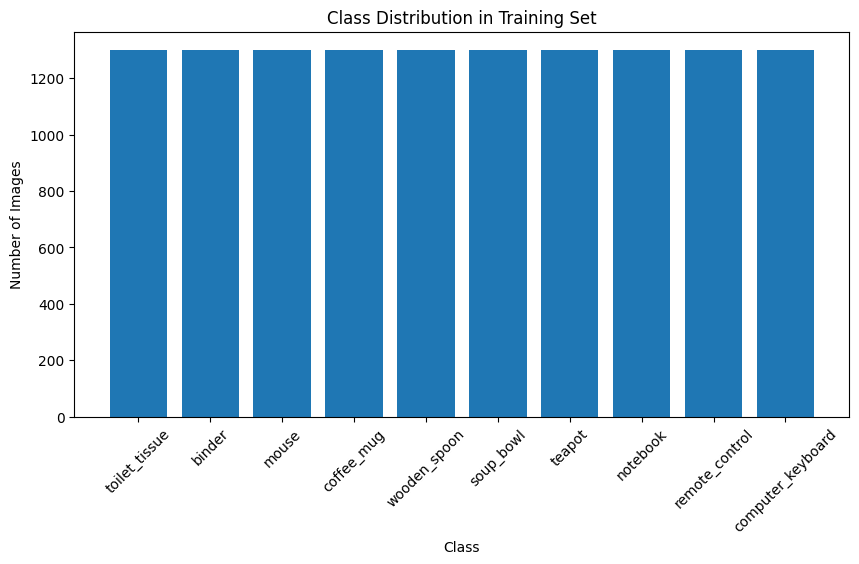

In [4]:
import os
import matplotlib.pyplot as plt

train_dir = "/content/dataset/ImageNetSubset/train"
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Display class counts
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Bar plot
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


### Feature Visualization Using a Pretrained CNN and PCA

This section visualizes high-level image features extracted by a pretrained
MobileNetV2 model. Instead of using the network for classification, the model
is used as a feature extractor to obtain compact representations of images.

Principal Component Analysis (PCA) is then applied to reduce the high-dimensional
feature vectors to two dimensions, allowing visualization of how images from
different classes are distributed in feature space. This helps assess whether
the pretrained model learns separable representations for the dataset classes.


/tmp/ipython-input-2377843260.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 13000 images belonging to 10 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


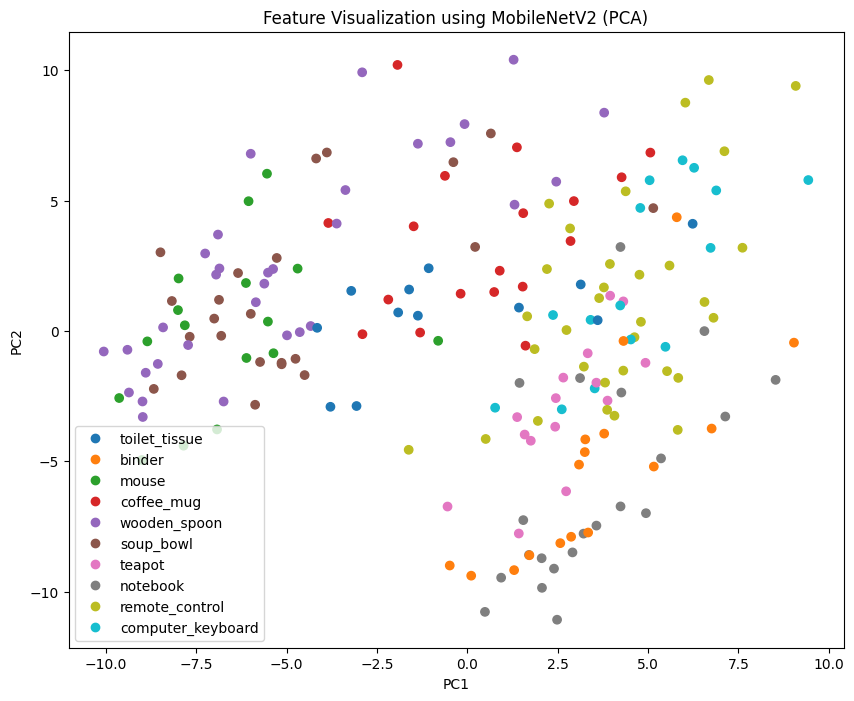

In [5]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

IMG_SIZE = 224

# Load pretrained MobileNetV2 up to the feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Load some samples from train set
datagen = ImageDataGenerator(rescale=1./255)
sample_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=200,   # 200 sample images for visualization
    shuffle=True
)

images, labels = next(sample_data)
features = base_model.predict(images)

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot reduced features
plt.figure(figsize=(10,8))
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=np.argmax(labels, axis=1), cmap='tab10')
plt.legend(scatter.legend_elements()[0], list(class_counts.keys()))
plt.title("Feature Visualization using MobileNetV2 (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
# @title
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

train_dir = "/content/dataset/ImageNetSubset/train"
test_dir  = "/content/dataset/ImageNetSubset/val"

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False   # freeze pretrained layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


Found 13000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 221s 498ms/step - accuracy: 0.7567 - loss: 0.7406 - val_accuracy: 0.8320 - val_loss: 0.5086
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 178s 437ms/step - accuracy: 0.8748 - loss: 0.3758 - val_accuracy: 0.8540 - val_loss: 0.4771
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 180s 442ms/step - accuracy: 0.8884 - loss: 0.3252 - val_accuracy: 0.8400 - val_loss: 0.5091
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 175s 430ms/step - accuracy: 0.8947 - loss: 0.3094 - val_accuracy: 0.8460 - val_loss: 0.5141
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 176s 432ms/step - accuracy: 0.9014 - loss: 0.2794 - val_accuracy: 0.8120 - val_loss: 0.5836
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 174s 427ms/step - accuracy: 0.9061 - loss: 0.2776 - val_accuracy: 0.8440 - val_loss: 0.5272
Epoch 7/10
184/407 ━━━━━━━━━━━━━━━━━━━━ 1:35 427ms/step - accuracy: 0.9084 - loss: 0.2630

### Transfer Learning with MobileNetV2

This code uses a pretrained MobileNetV2 model for classifying our dataset.  
- **Data:** Images are resized to `224×224` (`target_size`) and processed in batches of 32 (`batch_size`). Pixel values are rescaled to `[0,1]`.  
- **Model:** The MobileNetV2 base is frozen (`trainable=False`) and a new classification head is added with global average pooling, a dense layer, dropout, and a softmax output.  
- **Training:** The model is compiled with `adam` optimizer and `categorical_crossentropy` loss, then trained for 10 epochs with validation.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "/content/dataset/ImageNetSubset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    "/content/dataset/ImageNetSubset/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

base_model = MobileNetV2(include_top=False, input_shape=(224,224,3), weights="imagenet")
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_data, validation_data=test_data, epochs=10)


Found 13000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 72s 155ms/step - accuracy: 0.7978 - loss: 0.6236 - val_accuracy: 0.8480 - val_loss: 0.4872
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.9167 - loss: 0.2387 - val_accuracy: 0.8400 - val_loss: 0.5039
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 44s 107ms/step - accuracy: 0.9391 - loss: 0.1726 - val_accuracy: 0.8420 - val_loss: 0.5279
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.9446 - loss: 0.1562 - val_accuracy: 0.8380 - val_loss: 0.6314
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 45s 110ms/step - accuracy: 0.9561 - loss: 0.1286 - val_accuracy: 0.8420 - val_loss: 0.5946
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 0.9597 - loss: 0.1048 - val_accuracy: 0.8280 - val_loss: 0.7238
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 43s 105ms/step - accuracy: 0.9678 - loss: 0.0864 - val_accuracy: 0.8260 - val_loss: 0.6320
Epoch 8/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 50s 123ms/step - accuracy: 0.9675 - loss: 0

### Training Performance Visualization

This section plots the model's performance over training epochs.  

- **Left plot:** Shows training and validation accuracy, allowing us to see how well the model is learning and whether it generalizes to unseen data.  
- **Right plot:** Shows training and validation loss, indicating how the model's error decreases over time.  

These visualizations help identify issues like **overfitting** or **underfitting** and evaluate the effectiveness of the transfer learning setup with MobileNetV2.


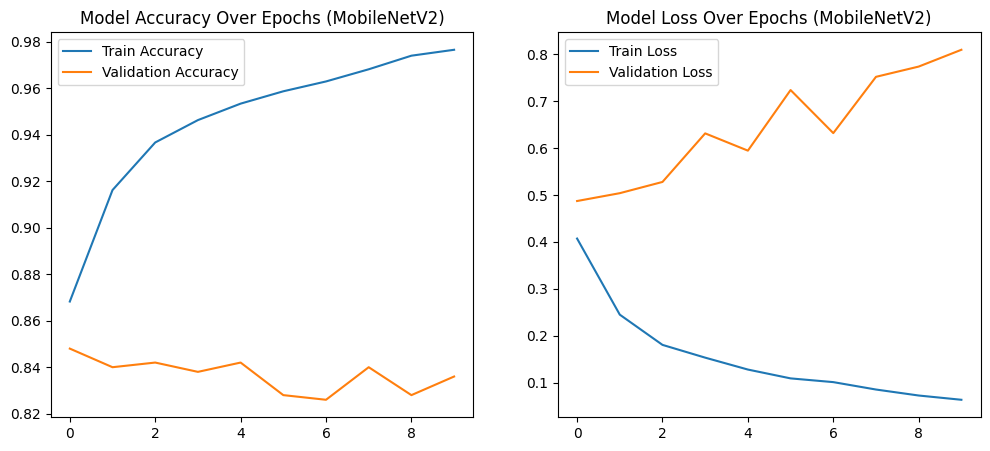

In [8]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs (MobileNetV2)")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs (MobileNetV2)")
plt.legend()

plt.show()


In [7]:
!pip install -q gdown
import gdown
FILE_ID = "1HQA0s5D2UxAfhT8sdTVUg7o82Y522y0K"
OUTPUT = "/content/xai-imagenet10-hard-test.zip"

gdown.download(
    f"https://drive.google.com/uc?id={FILE_ID}",
    OUTPUT,
    quiet=False
)

!unzip -q xai-imagenet10-hard-test.zip -d /content/dataset

Downloading...
From (original): https://drive.google.com/uc?id=1HQA0s5D2UxAfhT8sdTVUg7o82Y522y0K
From (redirected): https://drive.google.com/uc?id=1HQA0s5D2UxAfhT8sdTVUg7o82Y522y0K&confirm=t&uuid=342324df-cfba-4dfd-b9d3-c40194ca0c6c
To: /content/xai-imagenet10-hard-test.zip
100%|██████████| 1.47G/1.47G [00:24<00:00, 59.3MB/s]


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

custom_datagen = ImageDataGenerator(rescale=1./255)

custom_test_data = custom_datagen.flow_from_directory(
    "/content/dataset/xai-imagenet10-hard-test",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

loss, acc = model.evaluate(custom_test_data)
print("Custom Dataset Accuracy:", acc)


Found 4409 images belonging to 10 classes.
138/138 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4158 - loss: 4.2839
Custom Dataset Accuracy: 0.41483330726623535


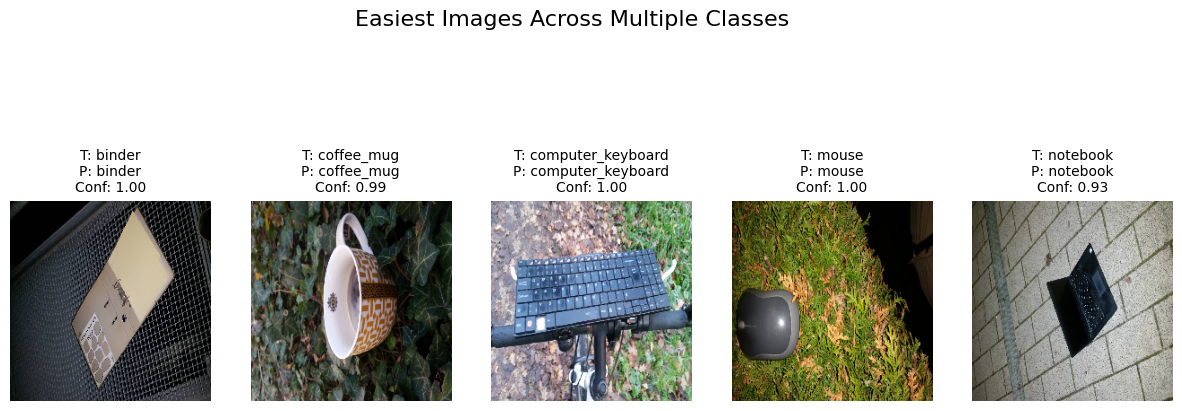

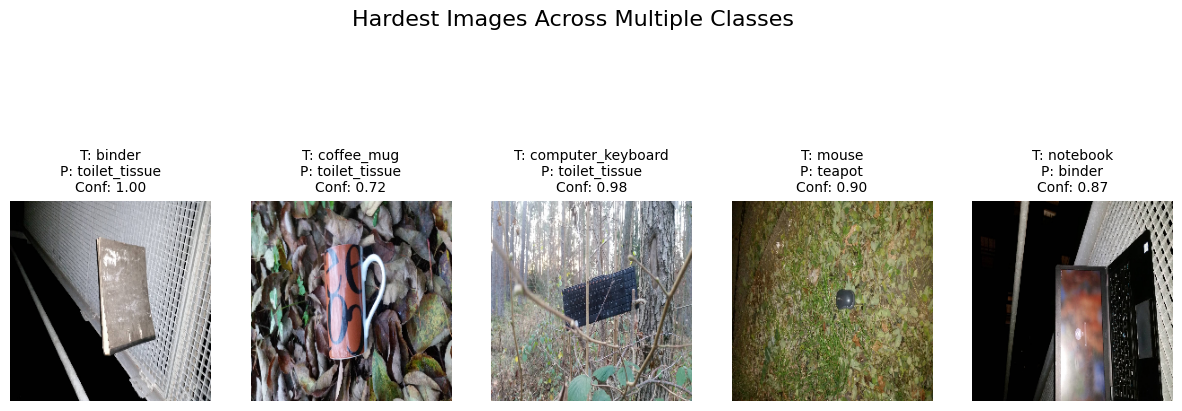

In [16]:
from collections import defaultdict

def get_balanced_indices(condition_fn, y_true, max_per_class=1, max_total=5):
    selected = []
    class_count = defaultdict(int)

    for idx in range(len(y_true)):
        if condition_fn(idx):
            cls = y_true[idx]
            if class_count[cls] < max_per_class:
                selected.append(idx)
                class_count[cls] += 1
        if len(selected) >= max_total:
            break

    return selected
easy_indices = get_balanced_indices(
    condition_fn=lambda i: (y_pred[i] == y_true[i]) and (confidence[i] > 0.9),
    y_true=y_true,
    max_per_class=1,
    max_total=5
)
hard_indices = get_balanced_indices(
    condition_fn=lambda i: (y_pred[i] != y_true[i]) or (confidence[i] < 0.4),
    y_true=y_true,
    max_per_class=1,
    max_total=5
)
show_image_grid(
    easy_indices,
    title="Easiest Images Across Multiple Classes",
    filepaths=filepaths,
    y_true=y_true,
    y_pred=y_pred,
    confidence=confidence,
    class_names=class_names
)

show_image_grid(
    hard_indices,
    title="Hardest Images Across Multiple Classes",
    filepaths=filepaths,
    y_true=y_true,
    y_pred=y_pred,
    confidence=confidence,
    class_names=class_names
)
